In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
#problem
hl = 2
hr = 1
ul = 0
ur = 0


# Spatial domain
ax = -5
bx = 5
ay = -2
by = 4
meqn = 2  # Number of equations in the system

# Gravity
g = 1

# Temporal domain
to = 0
Tfinal = 2

#Initial uo and ho for the newton method
ho = 0.1
uo = 0.01

# Numerical parameters
epislon = 1e-16
max_iter = 100

#Numerical values
qo = array([ho,uo])

#intial data
ql = array([hl,hl*ul])
qr = array([hr,hr*ur])

N = 200
nsteps = 30
dx = (bx - ax)/N

cfl = 0.5

a = 10
dt_est = cfl*dx/a

M = int(Tfinal/dt_est)+1

dt = Tfinal/M

t = linspace(to,Tfinal,M+1)

#x = linspace(ax+(dx/2),bx-(dx/2),N)

xe = linspace(ax,bx,N+1) #edge locations
x = xe[:-1] + dx/2       #Cell-center locations

#xc = linspace(ax,bx,N)
#dt = (Tfinal - to)/(nsteps-1)

dtdx = dt/dx



In [3]:
#flux
def f(q):
    q1 = q[0]
    q2 = q[1]
    flux = zeros(2)
    flux[0] = q2
    flux[1] = (((q2)**2)/q1) + (0.5*g*(q1)**2)
    return flux

In [4]:
from exact_rp import *

#rarefaction solution
hmr,umr = rare(ql,qr,g)

#shock solution
hms,hums = newton(qo,ql,qr,g,max_iter,epislon)

ums = hums/hms

#intermediate states
qmr = array([hmr,hmr*umr])
qms = array([hms,hms*ums])

shock_speed = sr(hms,qr,g)

laml = lam1(hl,ul,g)
lamr = lam1(hmr,umr,g)


In [5]:
#Initial conditions
qold1 = zeros(N)
qold2 = zeros(N)
qnew1 = zeros(N)
qnew2 = zeros(N)

qold1 = where(x <= 0 , ql[0], qr[0])
qold2 = where(x <= 0 , ql[1], qr[1]) 

qo = array([ho,uo])

<IPython.core.display.Javascript object>


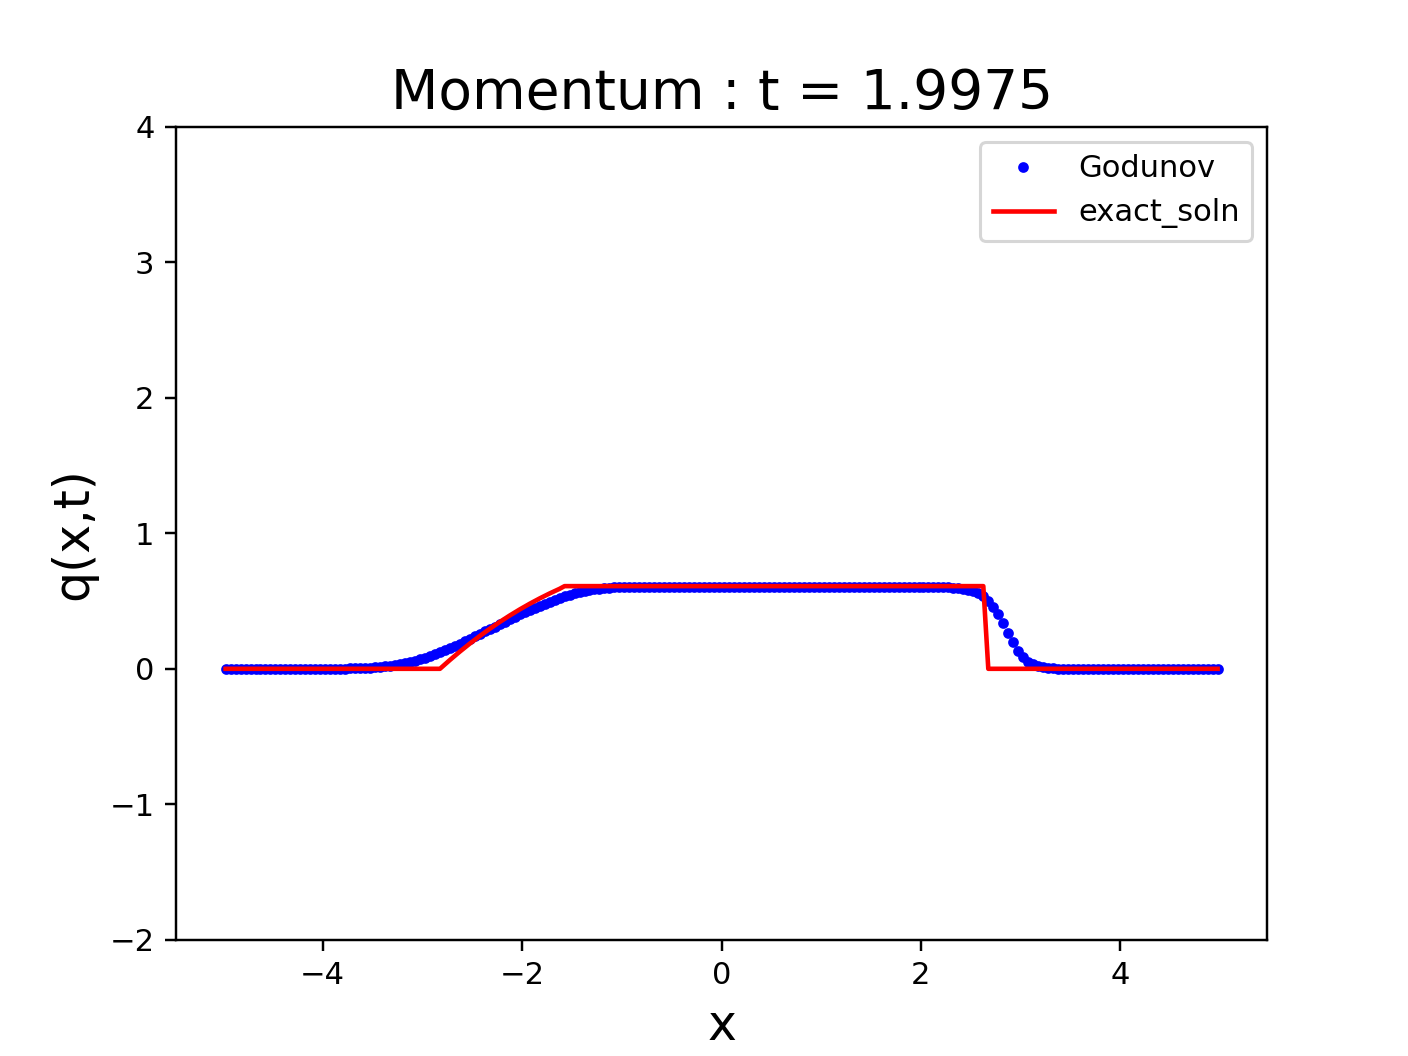

In [6]:
fig = figure(1)
clf()
# mq = 0 : Height field
# mq = 1 : Momentum field

mq = 1

if mq == 0:
    tstr = 'Height : t = {:.4f}'

    hdl, = plot(x,qnew1,'b.',markersize=5,label='Godunov')

else:
    tstr = 'Momentum : t = {:.4f}'
    hdl, = plot(x,qnew2,'b.',markersize=5,label='Godunov')
    
htitle = title(tstr.format(0),fontsize=18)

q0 = qexact(x,to,mq,qo,ql,qr,qmr,qms,lam1,g,max_iter,epislon)

hde, = plot(x,q0,'r-',markersize=5,label='exact_soln')


#Time loop
time = 0
for n in range(M):
    
    q = qexact(x,t[n],mq,qo,ql,qr,qmr,qms,lam1,g,max_iter,epislon)
    
    hde.set_ydata(q)
    
    '''#compute time step
    a = 0
    for i in range(N):
        a = max(a,abs(lamr))
        
    dt = cfl*dt/a
    
    if (time + dt)>0.5:
        dt = 0.5 - time
    elif time >= 0.5:
        break'''
            
    for i in range(N):
        if i == N-1:
            q1l = array([qold1[i],qold2[i]])
            q1r = array([qold1[i],qold2[i]])
        else:
            q1l = array([qold1[i],qold2[i]])
            q1r = array([qold1[i+1],qold2[i+1]])

        hms,hums = newton(qo,q1l,q1r,g,max_iter,epislon)
        q1e = array([hms,hums])
        
        f1 = f(q1e) #f_{i+1/2}
        
        if i == 0:
            q2l = array([qold1[i],qold2[i]])
            q2r = array([qold1[i],qold2[i]])
        else:
            q2l = array([qold1[i-1],qold2[i-1]])
            q2r = array([qold1[i],qold2[i]])
            
        hms,hums = newton(qo,q2l,q2r,g,max_iter,epislon)
        
        q2e = array([hms,hums])
        f2 = f(q2e) #f_{i-1/2}

        #soln at N+1

        qnew1[i] = qold1[i] - dtdx*(f1[0]-f2[0])

        qnew2[i] = qold2[i] - dtdx*(f1[1]-f2[1])

    
    if mq == 0:
        hdl.set_ydata(qnew1)
    else:
        hdl.set_ydata(qnew2)
        
    #overwrite the soln
    qold1 = qnew1
    qold2 = qnew2
    
    #update time step
    time = time + dt
    
    xlabel('x',fontsize=16)
    ylabel('q(x,t)',fontsize=16)
    htitle.set_text(tstr.format(t[n]))
    
    ylim([ay,by])
    legend()
    pause(0.1)

    fig.canvas.draw()        

    

In [7]:
hms

1.0000000000006979